<a href="https://colab.research.google.com/github/udayman/WhitesonATLASwork/blob/main/Reweighting_Aspiration_Recorrelate_Toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import scipy.stats
from scipy.stats import exponnorm
#gaussian and lognormal(turn into gaussian+lognormal) plots
#save and loading if elses


In [ ]:
!pip install lightgbm
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def plot_profile(x,y, ylim=None, range=(0,1), errorBars=True, label=None, color=None, bins=50, offset = 0):
   import scipy.stats
   import numpy
   import matplotlib.pyplot as plt


   means_result = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, range=range, statistic='mean')
   count_result = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, range=range, statistic='count')
   means, means2 = means_result.statistic # mean of y and y^2 in each bin
   cmeans, cmeans2 = count_result.statistic
   assert (cmeans == cmeans2).all()
   standard_deviations = numpy.sqrt(means2 - means**2)
   errors = standard_deviations/numpy.sqrt(cmeans)
   bin_edges = means_result.bin_edges
   bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
   if (errorBars):
       plt.errorbar(x=bin_centers + offset, y=means, yerr=errors, linestyle='none', marker='.',color=color,  label=label)
   else:
       plt.errorbar(x=bin_centers + offset, y=means, yerr=standard_deviations, linestyle='none', marker='.',color=color, label=label)
   #
   if (ylim != None):
       plt.legend()
       plt.ylim(ylim)

# Generate Data

1. training dataset, target dataset data: one feature with different behaviour
(if population it must have high enough variance to accomodate opposite correlation in subset like california in usa)
2. show plots for that feature alone for decision function for two datasets
3. (optional) show ideal classifier trained on each, and performance of classifeir trained in source dataset applied to target
4. show Aspiration can encorce required 1d correlation
5. show overall aspiration poruces similar classifier to one trained on target population, better than decorrelate

Imporve the variacne addition

!!!! Try double Gaussian which can be solvesd analytically and altered for target !!!!
Use better feature2. it should be simple, like a gaussian, that you can guess from first principles instead of this funny combination thing. correlate feature1 and feature 2 without touching feature2, change feature1 instead

maybe start simple and add the noisy variacne later or even mixing of features (not completely independent featuers)


For aspiration to work not only do you need to know the correlation you want, but also the variance (profile with std, not error). if you had directly added the decorrelation/correlation requirement as second loss this would just reduce scores but by using a second network you estimate the probability--- distance between aspired and true distributions.
If instead I train the R only on the means on big batches (like a profile, binned means) then I could remove the variance modelling requirement perhaps.



Adjust toy problem: swapping feature 2 directions for source target, number of gaussians, difference beteeen Gaussian centres for feature1 and feature2 (determines how useful each is), gaussian parameters.

maybe the 1D classifier is doomed to fail, use a 2D target classifier instead to model the variance?

In [ ]:
# useSquareF2 = True
correlateF1F2 = True #True is real value
# flipTargetF2Direction = True
useSquareF2 = False

flipTargetF2Direction = False

analyticalComplete = False
analytical1d = False
flipData = False
saveD1DT = False
saveD1DS = False
saveS = False
saveT = False
saveAspiration = False

In [ ]:
# Generate source dataset
n_source = 10**6
#modified values --- feature 1 variance, feature 3 variance, feature 2 variance, noise variance, centres sig and background changed

feature1 = np.random.normal(0, 1, n_source) #original feature1
feature3 = np.random.normal(0, 1, n_source) #original feature3
#feature1 = np.random.normal(0, 0, n_source) 
#feature3 = np.random.normal(0, 0, n_source)

if useSquareF2:
    feature2 = np.random.normal(0, 3, n_source) **2
else:
    #feature2 = np.concatenate([np.random.normal(0, 0.5, 9998 * n_source//10000), np.random.uniform(1.5, 5, 2 * n_source//10000)])
    #np.random.shuffle(feature2)
    #feature2 = np.random.normal(2.5, 2, n_source) #increasing feature 2 variance to 2 from 1
    feature2 = np.random.normal(0, 0.5, n_source) #original 2
#noise = np.random.normal(0, 1, n_source)

centres_sig_f1 = np.sin(feature2[:n_source//2])
centres_back_f1 = -np.sin(feature2[n_source//2:])

centres_sig_f3 = np.cos(feature2[:n_source//2])
centres_back_f3 = -np.cos(feature2[n_source//2:])

centres_sig_f2 = 0.3
centres_back_f2 = -0.3

feature1[:n_source//2] += centres_sig_f1
feature1[n_source//2:] += centres_back_f1
feature2[:n_source//2] += centres_sig_f2
feature2[n_source//2:] += centres_back_f2
feature3[:n_source//2] += centres_sig_f3
feature3[n_source//2:] += centres_back_f3

'''
if correlateF1F2:
    #reduce noise variance, 
    #noise = np.random.normal(1, 0.5, n_source) #trying to increase noise from 0.5 to 1.5
    #noise = np.random.normal(1, 0.1, n_source)
    
    
    noise = np.random.normal(1, 0.1, n_source) #originally was 1
    #noise = np.random.normal(1, 0, n_source)
    feature1 += noise*feature2
    feature3 += noise*feature2
'''

X_source = np.vstack( [feature1, feature2, feature3]).T
Y_source = np.ones(len(X_source))
Y_source[n_source//2:] = 0



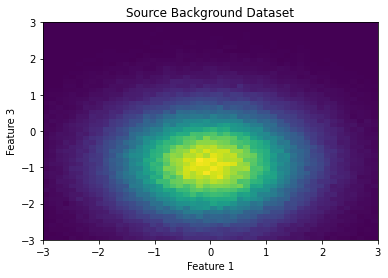

In [ ]:
plt.title("Source Background Dataset")
plt.hist2d(X_source[n_source//2:,0], X_source[n_source//2:,2], bins=50, range=[[-3,3],[-3,3]])
plt.xlabel("Feature 1")
plt.ylabel("Feature 3")
plt.savefig("gdrive/MyDrive/ToyPlots/sourcebackgroundf1f3.png")
plt.show()

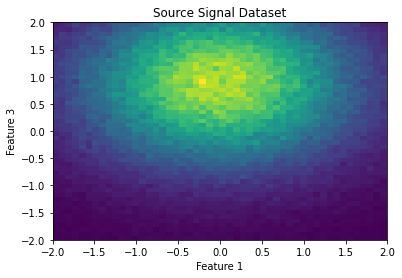

In [ ]:
plt.title("Source Signal Dataset")
plt.hist2d(X_source[:n_source//2,0], X_source[:n_source//2,2], bins=50, range=[[-2,2],[-2,2]])
plt.xlabel("Feature 1")
plt.ylabel("Feature 3")
plt.savefig("gdrive/MyDrive/ToyPlots/sourcesignalf1f3.png")
plt.show()

In [ ]:
# Generate target dataset
#modified values -- f2G params [1] variance and feature 1 and feature3 variance
n_target = n_source
#f2Gparams = np.array([[-1.5,2],[0.5,1]]) #increasing [1] to 2.5 from 1.5 //original first [-1.5,1] //something weird happening with 4.5


feature1 = np.random.normal(0, 1, n_target) #original feature1
feature3 = np.random.normal(0, 1, n_target) #original feature3

#feature3 = np.random.normal(0, 0, n_target) 
#feature1 = np.random.normal(0, 0, n_target)

if useSquareF2:
    feature2 = np.random.lognormal(2.5, 1.5, n_target) # different
else:
    #feature2 = np.random.lognormal(3, 10, n_target)
    #feature2 = np.random.normal(np.pi/2, np.pi/3, n_target)
    feature2 = np.random.normal(np.pi/2, 0.4, n_target)
    #feature2 = np.concatenate([np.random.lognormal(0, 0.5, 4 * n_target//5), np.random.normal(0, 1.5, n_target//5)])
    #feature2 = np.concatenate(
        #[np.random.normal(f2Gparams[0,0], f2Gparams[0,1], n_source//2), 
         #np.random.normal(f2Gparams[1,0], f2Gparams[1,1], n_source//2)] ) # different
    #feature2 = np.concatenate(
        #[np.random.normal(np.pi/2, np.pi/3, 9998 * n_target//10000), 
         #np.random.uniform(1.5, 5, 2 * n_target//10000)] ) # different
    #np.random.shuffle(feature2)


#flipped here
centres_sig_f1_target = np.sin(feature2[:n_target//2])
centres_back_f1_target = -np.sin(feature2[n_target//2:])

centres_sig_f3_target = np.cos(feature2[:n_target//2])
centres_back_f3_target = -np.cos(feature2[n_target//2:])

feature1[:n_target//2] += centres_sig_f1_target
feature1[n_target//2:] += centres_back_f1_target
feature2[:n_source//2] += centres_sig_f2
feature2[n_source//2:] += centres_back_f2
feature3[:n_target//2] += centres_sig_f3_target
feature3[n_target//2:] += centres_back_f3_target


'''
if correlateF1F2:
    #feature2[:n_target//2] += 0.4 #to add more seperation with signal and target, add to signal
    noise = np.random.normal(1, 0.1, n_target) #turn noise first then turn on feature1 and feature3, original noise
    
    #noise = np.random.normal(1, 0, n_target)
    feature1 += noise*feature2
    feature3 += noise*feature2
'''
    
'''
if flipTargetF2Direction:
    centres_sig_target[1] = centres_back[1]
    centres_back_target[1] = centres_sig[1]
'''

X_target = np.vstack( [feature1, feature2, feature3]).T
Y_target = np.ones(len(X_target))
Y_target[n_target//2:] = 0

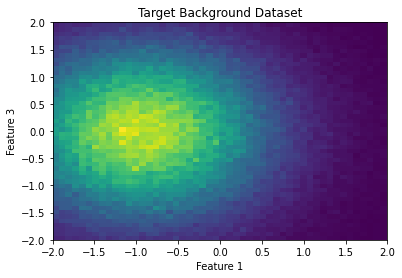

In [ ]:
plt.title("Target Background Dataset")
plt.hist2d(X_target[n_target//2:,0], X_target[n_target//2:,2], bins=50, range=[[-2,2],[-2,2]])
plt.xlabel("Feature 1")
plt.ylabel("Feature 3")
plt.savefig("gdrive/MyDrive/ToyPlots/targetbackgroundf1f3.png")
plt.show()

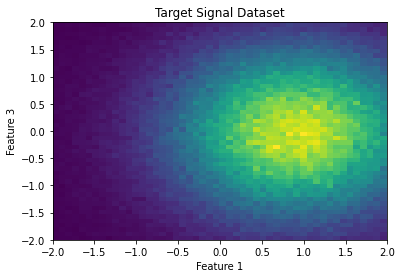

In [ ]:
plt.title("Target Signal Dataset")
plt.hist2d(X_target[:n_target//2,0], X_target[:n_target//2,2], bins=50, range=[[-2,2],[-2,2]])
plt.xlabel("Feature 1")
plt.ylabel("Feature 3")
plt.savefig("gdrive/MyDrive/ToyPlots/targetsignalf1f3.png")
plt.show()

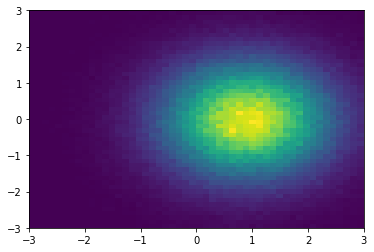

In [ ]:
counts_sb,ybins_sb,xbins_sb,image_sb = plt.hist2d(X_source[n_source//2:,0], X_source[n_source//2:,2], bins=50, range=[[-3,3],[-3,3]])
counts_ss,ybins_ss,xbins_ss,image_ss = plt.hist2d(X_source[:n_source//2,0], X_source[:n_source//2,2], bins=50, range=[[-3,3],[-3,3]])
counts_tb,ybins_tb,xbins_tb,image_tb = plt.hist2d(X_target[n_target//2:,0], X_target[n_target//2:,2], bins=50, range=[[-3,3],[-3,3]])
counts_ts,ybins_ts,xbins_ts,image_ts = plt.hist2d(X_target[:n_target//2,0], X_target[:n_target//2,2], bins=50, range=[[-3,3],[-3,3]])
plt.show()

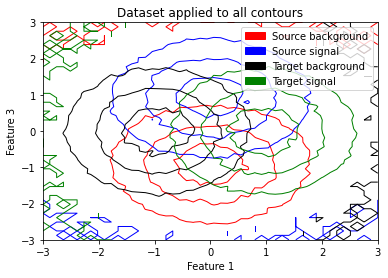

In [ ]:
import matplotlib.patches as mpatches

plt.title("Dataset applied to all contours")
#counts,ybins,xbins,image = plt.hist2d(X_source[n_source//2:,0], X_source[n_source//2:,2], bins=50, range=[[-3,3],[-3,3]])
plt.contour(counts_sb.transpose(),extent=[xbins_sb.min(),xbins_sb.max(),ybins_sb.min(),ybins_sb.max()],linewidths=1, levels = 3, colors='red')
plt.contour(counts_ss.transpose(),extent=[xbins_ss.min(),xbins_ss.max(),ybins_ss.min(),ybins_ss.max()],linewidths=1, levels = 3, colors='blue')
plt.contour(counts_tb.transpose(),extent=[xbins_tb.min(),xbins_tb.max(),ybins_tb.min(),ybins_tb.max()],linewidths=1, levels = 3, colors='black')
plt.contour(counts_ts.transpose(),extent=[xbins_ts.min(),xbins_ts.max(),ybins_ts.min(),ybins_ts.max()],linewidths=1, levels = 3, colors='green')
plt.xlabel("Feature 1")
plt.ylabel("Feature 3")
red_patch = mpatches.Patch(color='red', label='Source background')
blue_patch = mpatches.Patch(color='blue', label='Source signal')
black_patch = mpatches.Patch(color='black', label='Target background')
green_patch = mpatches.Patch(color='green', label='Target signal')
plt.legend(handles=[red_patch, blue_patch, black_patch, green_patch])
plt.savefig("gdrive/MyDrive/ToyPlots/sourcebackgroundf1f3.png")
plt.show()

In [ ]:
if flipData:
  tempx = X_source.copy()
  tempy = Y_source.copy()
  X_source = X_target.copy()
  Y_source = Y_target.copy()
  X_target = tempx.copy()
  Y_target = tempy.copy()

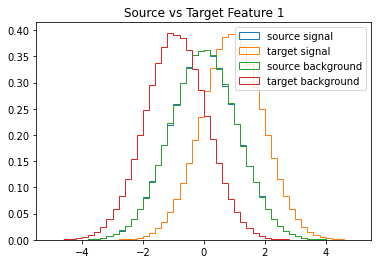

In [ ]:
plt_range = (-5,5)

plt.title("Source vs Target Feature 1")
plt.hist(X_source[:n_source//2,0], bins=50, density=1, histtype = "step", label="source signal", range = plt_range)
plt.hist(X_target[:n_source//2,0], bins=50, density=1, histtype = "step", label="target signal", range = plt_range)
plt.hist(X_source[n_source//2:,0], bins=50, density=1, histtype = "step", label="source background", range = plt_range)
plt.hist(X_target[n_source//2:,0], bins=50, density=1, histtype = "step", label="target background", range = plt_range)
plt.legend()
plt.show()

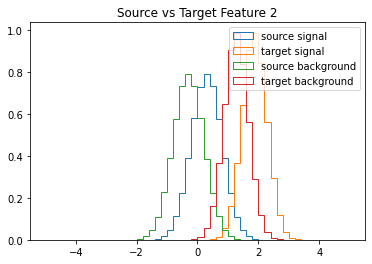

In [ ]:
plt.title("Source vs Target Feature 2")
plt.hist(X_source[:n_source//2,1], bins=50, density=1, histtype = "step", label="source signal", range = plt_range)
plt.hist(X_target[:n_source//2,1], bins=50, density=1, histtype = "step", label="target signal", range = plt_range)
plt.hist(X_source[n_source//2:,1], bins=50, density=1, histtype = "step", label="source background", range = plt_range)
plt.hist(X_target[n_source//2:,1], bins=50, density=1, histtype = "step", label="target background", range = plt_range)
plt.legend()
plt.savefig("gdrive/MyDrive/ToyPlots/sourcetargetf2.png")
plt.show()

In [ ]:
len(X_source[X_source[:,1]>1.9]) #source

328

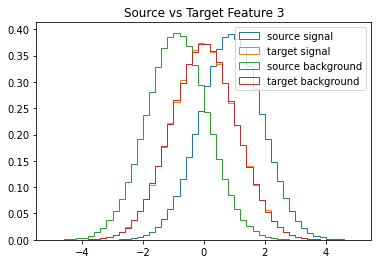

In [ ]:
plt.title("Source vs Target Feature 3")
plt.hist(X_source[:n_source//2,2], bins=50, density=1, histtype = "step", label="source signal", range = plt_range)
plt.hist(X_target[:n_source//2,2], bins=50, density=1, histtype = "step", label="target signal", range = plt_range)
plt.hist(X_source[n_source//2:,2], bins=50, density=1, histtype = "step", label="source background", range = plt_range)
plt.hist(X_target[n_source//2:,2], bins=50, density=1, histtype = "step", label="target background", range = plt_range)
plt.legend()
plt.show()

### Split Train-Test

In [ ]:
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
train_size = 0.75 # 0.1 # !!!
X_s_train, X_s_test, y_s_train, y_s_test, = \
    train_test_split(X_source, Y_source, train_size=train_size, shuffle=True, random_state=1)
# do target seprately so they are not shuffled in unison
X_t_train, X_t_test, y_t_train, y_t_test, = \
    train_test_split(X_target, Y_target, train_size=train_size, shuffle=True, random_state=2)

In [ ]:
X_source[:,1]

array([ 0.77331788,  0.50705574,  0.12556691, ..., -1.14774109,
       -0.07230097, -0.61648578])

##Train on Signal with Mass only

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

'''
inputs = Input(shape=(1,))
Dx = Dense(300, activation="relu")(inputs)
Dx = Dense(300, activation="relu")(Dx)
Dx = Dense(300, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D1DSigM = Model(inputs=[inputs], outputs=[Dx])
D1DSigM.compile(loss="binary_crossentropy", optimizer="adam")
'''

D1DSigM = lgb.LGBMClassifier(
       objective='binary')
X_sigM = np.concatenate((X_source[:n_source//2,1], X_target[:n_target//2,1]))
y_sigM = np.concatenate((np.zeros(len(X_source) - n_source//2), np.ones(len(X_target) - n_target//2)))

shuffler = np.random.permutation(len(X_sigM))
X_sigM = X_sigM[shuffler]
y_sigM = y_sigM[shuffler]
#D1DSigM.fit(X_sigM, y_sigM)
D1DSigM.fit(X_sigM.reshape(-1, 1), y_sigM) #from 2

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

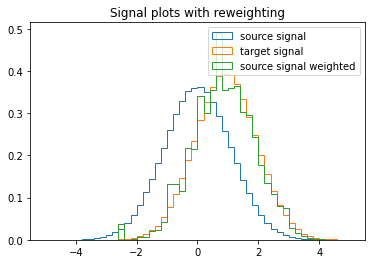

In [ ]:
weight_result = D1DSigM.predict_proba(X_source[:n_source//2,1].reshape(-1,1))[:, 1]
#weight_result = D1DSigM.predict(X_source[:n_source//2,1])
sample_weight_signal_source = 1/((1/weight_result)-1) #manipulating equation

plt.title("Signal plots with reweighting")
plt.hist(X_source[:n_source//2,0], bins=50, density=1, histtype = "step", label="source signal", range = plt_range)
plt.hist(X_target[:n_target//2,0], bins=50, density=1, histtype = "step", label="target signal", range = plt_range)
plt.hist(X_source[:n_source//2,0], bins=50, density=1, histtype = "step", label="source signal weighted", weights = sample_weight_signal_source, range = plt_range)
plt.legend()
plt.show()

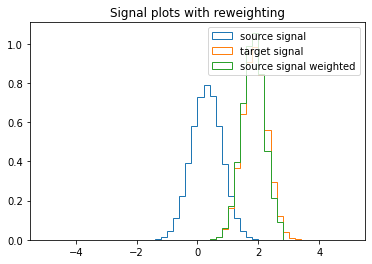

In [ ]:
plt.title("Signal plots with reweighting")
plt.hist(X_source[:n_source//2,1], bins=50, density=1, histtype = "step", label="source signal", range = plt_range)
plt.hist(X_target[:n_target//2,1], bins=50, density=1, histtype = "step", label="target signal", range = plt_range)
plt.hist(X_source[:n_source//2,1], bins=50, density=1, histtype = "step", label="source signal weighted", weights = sample_weight_signal_source, range = plt_range)
plt.legend()
plt.show()

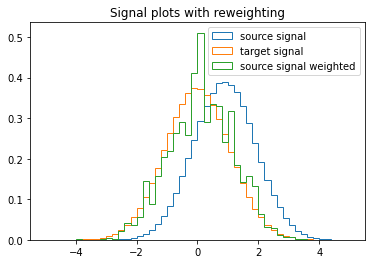

In [ ]:
plt.title("Signal plots with reweighting")
plt.hist(X_source[:n_source//2,2], bins=50, density=1, histtype = "step", label="source signal", range = plt_range)
plt.hist(X_target[:n_target//2,2], bins=50, density=1, histtype = "step", label="target signal", range = plt_range)
plt.hist(X_source[:n_source//2,2], bins=50, density=1, histtype = "step", label="source signal weighted", weights = sample_weight_signal_source, range = plt_range)
plt.legend()
plt.show()

In [ ]:
#print(sum(sample_weight_signal_source[X_source[:n_source//2,2]>13]))

In [ ]:
#print(sum(sample_weight_signal_source[X_source[:n_source//2,2]>13])/ sum(sample_weight_signal_source))

##Train on Signal Background only

In [ ]:
#do same for background
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

'''
inputs = Input(shape=(1,))
Dx = Dense(300, activation="relu")(inputs)
Dx = Dense(300, activation="relu")(Dx)
Dx = Dense(300, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D1DBackM = Model(inputs=[inputs], outputs=[Dx])
D1DBackM.compile(loss="binary_crossentropy", optimizer="adam")
'''
D1DBackM = lgb.LGBMClassifier(
       objective='binary')


X_backM = np.concatenate((X_source[n_source//2:,1], X_target[n_target//2:,1]))
y_backM = np.concatenate((np.zeros(len(X_source[n_source//2:,])), np.ones(len(X_target[n_target//2:,]))))
shuffler = np.random.permutation(len(X_backM))
X_backM = X_backM[shuffler]
y_backM = y_backM[shuffler]
D1DBackM.fit(X_backM.reshape(-1, 1), y_backM)
#D1DBackM.fit(X_backM, y_backM)

KeyboardInterrupt: ignored

In [ ]:
weight_result = D1DBackM.predict_proba(X_source[n_source//2:,1].reshape(-1,1))[:,1]
#weight_result = D1DBackM.predict(X_source[n_source//2:, 1])
sample_weight_background_source = 1/((1/weight_result)-1) #manipulating equation

plt.title("Background plots with reweighting")
plt.hist(X_source[n_source//2:,0], bins=50, density=1, histtype = "step", label="source background", range = plt_range)
plt.hist(X_target[n_target//2:,0], bins=50, density=1, histtype = "step", label="target background", range = plt_range)
plt.hist(X_source[n_source//2:,0], bins=50, density=1, histtype = "step", label="source background weighted", weights = sample_weight_background_source, range = plt_range)
plt.legend()
plt.show()

In [ ]:
plt.title("Background plots with reweighting")
plt.hist(X_source[n_source//2:,1], bins=50, density=1, histtype = "step", label="source background", range = plt_range)
plt.hist(X_target[n_target//2:,1], bins=50, density=1, histtype = "step", label="target background", range = plt_range)
plt.hist(X_source[n_source//2:,1], bins=50, density=1, histtype = "step", label="source background weighted", weights = sample_weight_background_source, range = plt_range)
plt.legend()
plt.show()

In [ ]:
plt.title("Background plots with reweighting")
plt.hist(X_source[n_source//2:,2], bins=50, density=1, histtype = "step", label="source background", range = plt_range)
plt.hist(X_target[n_target//2:,2], bins=50, density=1, histtype = "step", label="target background", range = plt_range)
plt.hist(X_source[n_source//2:,2], bins=50, density=1, histtype = "step", label="source background weighted", weights = sample_weight_background_source, range = plt_range)
plt.legend()
plt.show()

In [ ]:
sample_weight_signal_source *= sum(sample_weight_background_source)/sum(sample_weight_signal_source)
sample_weight = np.concatenate((sample_weight_signal_source, sample_weight_background_source))

shuffler = np.random.permutation(len(X_source))
X_source_SigB = X_source[shuffler]
y_source_SigB = Y_source[shuffler]
sample_weight = sample_weight[shuffler]

inputs = Input(shape=(X_source_SigB.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
DSigB = Model(inputs=[inputs], outputs=[Dx])
DSigB.compile(loss="binary_crossentropy", optimizer="adam")

DSigB.fit(X_source_SigB, y_source_SigB, sample_weight = sample_weight, epochs=2)

In [ ]:
pred_SWonT_predSigB = DSigB.predict(X_target).ravel()
plot_SWonT_predSigB = DSigB.predict(X_t_test).ravel()
auc_SWonT = roc_auc_score(y_true=Y_target, y_score=pred_SWonT_predSigB)
print("SWonT value: ", auc_SWonT)

In [ ]:
#train a neural network for signal vs background
shuffler = np.random.permutation(len(X_target))
X_target_SigB = X_target[shuffler]
y_target_SigB = Y_target[shuffler]

inputs = Input(shape=(X_target_SigB.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
DTSigB = Model(inputs=[inputs], outputs=[Dx])
DTSigB.compile(loss="binary_crossentropy", optimizer="adam")

DTSigB.fit(X_target_SigB, y_target_SigB, epochs=2)

In [ ]:
pred_TonT_predSigB = DTSigB.predict(X_target).ravel()
auc_TonT = roc_auc_score(y_true=Y_target, y_score=pred_TonT_predSigB)
print("TonT value: ", auc_TonT)

In [ ]:
#train a neural network for signal vs background
shuffler = np.random.permutation(len(X_source))
X_source_SigBS = X_source[shuffler]
y_source_SigBS = Y_source[shuffler]

inputs = Input(shape=(X_source_SigBS.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
DSigBS = Model(inputs=[inputs], outputs=[Dx])
DSigBS.compile(loss="binary_crossentropy", optimizer="adam")

DSigBS.fit(X_source_SigBS, y_source_SigBS, epochs=2)

In [ ]:
pred_SonT_predSigB = DSigBS.predict(X_target).ravel()
auc_SonT = roc_auc_score(y_true=Y_target, y_score=pred_SonT_predSigB)
print("SonT value: ", auc_SonT)

In [ ]:
pip install PermutationImportancePhysics

In [ ]:
from permutationimportancephysics.PermutationImportance import PermulationImportance
pi = PermulationImportance(model=DSigBS, X=X_target,y=Y_target,n_iterations=3,usePredict_poba=False,
                      scoreFunction="AUC")
pi.dislayResults()

In [ ]:
plt = pi.plotBars()
plt.show()

In [ ]:
from permutationimportancephysics.PermutationImportance import PermulationImportance
pi = PermulationImportance(model=DSigBS, X=X_source,y=Y_source,n_iterations=3,usePredict_poba=False,
                      scoreFunction="AUC")
pi.dislayResults()

In [ ]:
plt = pi.plotBars()
plt.show()

In [ ]:
DSigBSgb = lgb.LGBMClassifier(
       objective='binary')
DSigBSgb.fit(X_source_SigBS, y_source_SigBS)

In [ ]:
pred_SigBSgb = DSigBSgb.predict_proba(X_target)[:,1]
auc_SonTgb = roc_auc_score(y_true=Y_target, y_score=pred_SigBSgb)
print("SonT value: ", auc_SonTgb)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
augmented_model = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

In [ ]:
#train model
augmented_model.fit(X_source_SigBS, y_source_SigBS)
Y_predict_augOnSys = augmented_model.predict_proba(X_target)[:,1]
auc_SonTa = roc_auc_score(y_true=Y_target, y_score=Y_predict_augOnSys)
print("SonT value: ", auc_SonTa)

In [ ]:
Y_predict_augSonS = augmented_model.predict_proba(X_source)[:,1]
auc_SonSa = roc_auc_score(y_true=Y_source, y_score=Y_predict_augSonS)
print("SonS value: ", auc_SonSa)

In [ ]:
#ADABoost
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()
adaboost.fit(X_source_SigBS, y_source_SigBS)

In [ ]:
Y_predict_adaboost = adaboost.predict_proba(X_target)[:,1]
auc_SonTadaboost = roc_auc_score(y_true=Y_target, y_score=Y_predict_adaboost)
print("SonT value: ", auc_SonTadaboost)

In [ ]:
Y_predict_adaboost = adaboost.predict_proba(X_source)[:,1]
auc_SonSadaboost = roc_auc_score(y_true=Y_source, y_score=Y_predict_adaboost)
print("SonS value: ", auc_SonSadaboost)

In [ ]:
from permutationimportancephysics.PermutationImportance import PermulationImportance
pi = PermulationImportance(model=adaboost, X=X_target,y=Y_target,n_iterations=3,usePredict_poba=True,
                      scoreFunction="AUC")
pi.dislayResults()

In [ ]:
plt = pi.plotBars()
plt.show()

In [ ]:
pi = PermulationImportance(model=adaboost, X=X_source,y=Y_source,n_iterations=3,usePredict_poba=True,
                      scoreFunction="AUC")
pi.dislayResults()

In [ ]:
plt = pi.plotBars()
plt.show()

In [ ]:
#SVM models
'''
from sklearn import svm
linsvm = svm.SVC(kernel = 'linear')
linsvm.fit(X_source_SigBS, y_source_SigBS)
'''

In [ ]:
'''
Y_predict_linsvm = linsvm.predict_proba(X_target)[:,1]
auc_SonTlinsvm = roc_auc_score(y_true=Y_target, y_score=Y_predict_linsvm)
print("SonT value: ", auc_SonTlinsvm)
'''

In [ ]:
'''
Y_predict_linsvm = linsvm.predict_proba(X_source)[:,1]
auc_SonSlinsvm = roc_auc_score(y_true=Y_source, y_score=Y_predict_linsvm)
print("SonS value: ", auc_SonSlinsvm)
'''

In [ ]:
'''
rbmsvm = svm.SVC()
rbmsvm.fit(X_source_SigBS, y_source_SigBS)
'''

In [ ]:
'''
Y_predict_rbmsvm = rbmsvm.predict_proba(X_target)[:,1]
auc_SonTrbmsvm = roc_auc_score(y_true=Y_target, y_score=Y_predict_rbmsvm)
print("SonT value: ", auc_SonTrbmsvm)
'''

In [ ]:
'''
Y_predict_rbmsvm = rbmsvm.predict_proba(X_source)[:,1]
auc_SonSrbmsvm = roc_auc_score(y_true=Y_source, y_score=Y_predict_rbmsvm)
print("SonS value: ", auc_SonSrbmsvm)
'''

# Train on Source Distribution

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score


#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_s_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
DSnn = Model(inputs=[inputs], outputs=[Dx])
DSnn.compile(loss="binary_crossentropy", optimizer="adam")

DSnn.fit(X_s_train, y_s_train, epochs=2)

In [ ]:
from sklearn.metrics import roc_auc_score
y_SonS_prednn = DSnn.predict(X_s_test).ravel()
y_SonT_prednn = DSnn.predict(X_t_test).ravel()
y_SonS_pred_train = DSnn.predict(X_s_train).ravel()
auc_test_SonSnn = roc_auc_score(y_true=y_s_test, y_score=y_SonS_prednn,)
auc_test_SonTnn = roc_auc_score(y_true=y_t_test, y_score=y_SonT_prednn,)
print (auc_test_SonSnn, auc_test_SonTnn)

In [ ]:
y_SonT_prednnfull = DSnn.predict(X_target).ravel()
auc_test_SonTnnfull = roc_auc_score(y_true=Y_target, y_score=y_SonT_prednnfull,)
print(auc_test_SonTnnfull)

In [ ]:
plot_profile(y_SonS_prednn, X_s_test[:,1], bins=30)
plot_profile(y_SonT_prednn, X_t_test[:,1], bins=30)
plt.show()

In [ ]:
# analytical solution
'''
if not useSquareF2:
    class clf_S:
        def __init__(self,in_f1Gparams):
            self.in_f1Gparams = in_f1Gparams

        def predict(self,X):
            from scipy.stats import norm
            gs = norm(self.in_f1Gparams[0] + centres_sig[1],self.in_f1Gparams[1] ).pdf
            gb = norm(self.in_f1Gparams[0] + centres_back[1],self.in_f1Gparams[1] ).pdf

            gsf1 = norm(0 + centres_sig_target[0], 1 ).pdf
            gbf1 = norm(0 + centres_back_target[0], 1 ).pdf
            # how to account for correlated part of f1 with f2???

            # wrong.. need to accoutn for f1 dependence on f2
            p_signal =  gs(X[:,1])* gsf1(X[:,0]) * gsf1(X[:,2])
            p_background =  gb(X[:,1]) * gbf1(X[:,0]) * gbf1(X[ :,2])
            score = p_signal/(p_signal + p_background)
            return score
    if (flipData):
      DT = clf_S(np.array([1,1]))
    else:
      DS = clf_S(np.array([1,1]))

else:
    inputs = Input(shape=(X_t_train.shape[1],))
    Dx = Dense(32, activation="relu")(inputs)
    #Dx = Dense(32, activation="relu")(Dx)
    #Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(1, activation="sigmoid")(Dx)
    DS = Model(inputs=[inputs], outputs=[Dx])
    DS.compile(loss="binary_crossentropy", optimizer="adam")
    DS.fit(X_t_train, y_t_train, epochs=3)
  '''

In [ ]:
# analytical solution
'''
if not useSquareF2:
    class clf_T:
        def __init__(self,in_f2Gparams):
    #         from scipy.stats import norm
    #         gs1 = norm(in_f2Gparams[0,0] + centres_sig_target[1],in_f2Gparams[0,1] ).pdf
    #         gs2 = norm(in_f2Gparams[1,0] + centres_sig_target[1],in_f2Gparams[1,1] ).pdf
    #         gb1 = norm(in_f2Gparams[0,0] + centres_back_target[1],in_f2Gparams[0,1] ).pdf
    #         gb2 = norm(in_f2Gparams[1,0] + centres_back_target[1],in_f2Gparams[1,1] ).pdf
            self.in_f2Gparams = in_f2Gparams

        def predict(self,X):
            from scipy.stats import norm
            gs1 = norm(self.in_f2Gparams[0,0] + centres_sig_target[1],self.in_f2Gparams[0,1] ).pdf
            gs2 = norm(self.in_f2Gparams[1,0] + centres_sig_target[1],self.in_f2Gparams[1,1] ).pdf
            gb1 = norm(self.in_f2Gparams[0,0] + centres_back_target[1],self.in_f2Gparams[0,1] ).pdf
            gb2 = norm(self.in_f2Gparams[1,0] + centres_back_target[1],self.in_f2Gparams[1,1] ).pdf

            gsf1 = norm(0 + centres_sig_target[0], 1 ).pdf
            gbf1 = norm(0 + centres_back_target[0], 1 ).pdf
            # how to account for correlated part of f1 with f2???

            # wrong.. need to accoutn for f1 dependence on f2
            p_signal =  (gs1(X[:,1]) + gs2(X[:,1]))/2. * gsf1(X[:,0]) * gsf1(X[:,2])
            p_background =  (gb1(X[:,1]) + gb2(X[:,1]))/2. * gbf1(X[:,0]) * gbf1(X[:,2])
            score = p_signal/(p_signal + p_background)
            return score
    if flipData:
      DS = clf_T(f2Gparams)
    else:
      DT = clf_T(f2Gparams)

else:
    inputs = Input(shape=(X_t_train.shape[1],))
    Dx = Dense(32, activation="relu")(inputs)
    #Dx = Dense(32, activation="relu")(Dx)
    #Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(1, activation="sigmoid")(Dx)
    DT = Model(inputs=[inputs], outputs=[Dx])
    DT.compile(loss="binary_crossentropy", optimizer="adam")
    DT.fit(X_t_train, y_t_train, epochs=3)
'''

In [ ]:
'''
if analyticalComplete:
  from sklearn.metrics import roc_auc_score
  y_SonS_pred = DS.predict(X_s_test).ravel()
  y_SonT_pred = DS.predict(X_t_test).ravel()
  auc_test_SonS = roc_auc_score(y_true=y_s_test, y_score=y_SonS_pred,)
  auc_test_SonT = roc_auc_score(y_true=y_t_test, y_score=y_SonT_pred,)
#print (auc_test_SonS, auc_test_SonT)
'''

In [ ]:
plot_profile(y_SonS_prednn, X_s_test[:,1], bins=30)
plot_profile(y_SonT_prednn, X_t_test[:,1], bins=30)
plt.show()

In [ ]:
if not analyticalComplete:
  y_SonS_pred = y_SonS_prednn
  y_SonT_pred = y_SonT_prednn
  auc_test_SonS = auc_test_SonSnn
  auc_test_SonT = auc_test_SonTnn
  DS = DSnn

# If we could train on target distribution

In [ ]:
#neural network

#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_t_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
DTnn = Model(inputs=[inputs], outputs=[Dx])
DTnn.compile(loss="binary_crossentropy", optimizer="adam")
DTnn.fit(X_t_train, y_t_train, epochs=2)

In [ ]:
from sklearn.metrics import roc_auc_score
y_TonS_prednn = DTnn.predict(X_s_test).ravel()
y_TonT_prednn = DTnn.predict(X_t_test).ravel()
auc_test_TonSnn = roc_auc_score(y_true=y_s_test, y_score=y_TonS_prednn,)
auc_test_TonTnn = roc_auc_score(y_true=y_t_test, y_score=y_TonT_prednn,)
print (auc_test_TonSnn, auc_test_TonTnn)

In [ ]:
plot_profile(y_TonS_prednn, X_s_test[:,1], bins=30)
plot_profile(y_TonT_prednn, X_t_test[:,1], bins=30)
plt.show()

In [ ]:
'''
if analyticalComplete:
  y_TonS_pred = DT.predict(X_s_test).ravel()
  y_TonT_pred = DT.predict(X_t_test).ravel()
  y_TonS_pred_train = DT.predict(X_s_train).ravel()
  auc_test_TonS = roc_auc_score(y_true=y_s_test, y_score=y_TonS_pred,)
  auc_test_TonT = roc_auc_score(y_true=y_t_test, y_score=y_TonT_pred,)
  print (auc_test_TonS, auc_test_TonT)

  plot_profile(y_TonS_pred, X_s_test[:,1], bins=30)
  plot_profile(y_TonT_pred, X_t_test[:,1], bins=30)
  plt.show()
'''

In [ ]:
if not analyticalComplete:
  y_TonS_pred = y_TonS_prednn
  y_TonT_pred = y_TonT_prednn
  y_TonS_pred_train = DTnn.predict(X_s_train).ravel()
  auc_test_TonS = auc_test_TonSnn
  auc_test_TonT = auc_test_TonTnn
  DT = DTnn

In [ ]:
plot_profile(X_s_test[:,1], y_SonS_pred, bins=30, range=(-5,8),label="SonS")
plot_profile(X_t_test[:,1], y_TonT_pred, bins=30, range=(-5,8),label="TonT")
plt.title("Ideal Score vs Feature2 distribution on each datasets")
plt.legend()
plt.show()



# Simulate only having info on feature2 relation with decision function for target

In [ ]:
'''
# analytical solution:

if not useSquareF2:
    class clf_1DT:
        def __init__(self,in_f2Gparams):
    #         from scipy.stats import norm
    #         gs1 = norm(in_f2Gparams[0,0] + centres_sig_target[1],in_f2Gparams[0,1] ).pdf
    #         gs2 = norm(in_f2Gparams[1,0] + centres_sig_target[1],in_f2Gparams[1,1] ).pdf
    #         gb1 = norm(in_f2Gparams[0,0] + centres_back_target[1],in_f2Gparams[0,1] ).pdf
    #         gb2 = norm(in_f2Gparams[1,0] + centres_back_target[1],in_f2Gparams[1,1] ).pdf
            self.in_f2Gparams = in_f2Gparams

        def predict(self,X):
            from scipy.stats import norm
            gs1 = norm(self.in_f2Gparams[0,0] + centres_sig_target[1],self.in_f2Gparams[0,1] ).pdf
            gs2 = norm(self.in_f2Gparams[1,0] + centres_sig_target[1],self.in_f2Gparams[1,1] ).pdf
            gb1 = norm(self.in_f2Gparams[0,0] + centres_back_target[1],self.in_f2Gparams[0,1] ).pdf
            gb2 = norm(self.in_f2Gparams[1,0] + centres_back_target[1],self.in_f2Gparams[1,1] ).pdf

            p_signal =  (gs1(X) + gs2(X))/2.
            p_background =  (gb1(X) + gb2(X))/2.
            score = p_signal/(p_signal + p_background)
            return score
    if flipData:
      D1DS = clf_1DT(f2Gparams)
    else:
      D1DT = clf_1DT(f2Gparams)

else:
    inputs1d = Input(shape=(1,))
    Dx = Dense(32, activation="relu", kernel_regularizer='l2', bias_regularizer='l2',)(inputs1d)
    #Dx = Dense(32, activation="relu")(Dx)
    #Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(1, activation="sigmoid", kernel_regularizer='l2', bias_regularizer='l2',)(Dx)
    D1DT = Model(inputs=[inputs1d], outputs=[Dx])
    D1DT.compile(loss="binary_crossentropy", optimizer="adam")
    D1DT.fit(X_t_train[:,1], y_t_train, epochs=2)

'''

In [ ]:
'''
# analytical solution:
if not useSquareF2:
    class clf_1DS:
        def __init__(self,in_f1Gparams):
            self.in_f1Gparams = in_f1Gparams

        def predict(self,X):
            from scipy.stats import norm
            gs = norm(self.in_f1Gparams[0] + centres_sig[1],self.in_f1Gparams[1] ).pdf
            gb = norm(self.in_f1Gparams[0] + centres_back[1],self.in_f1Gparams[1] ).pdf

            p_signal =  gs(X)
            p_background =  gb(X)
            score = p_signal/(p_signal + p_background)
            return score

    if flipData:
      D1DT = clf_1DS(np.array([1,1]))
    else:
      D1DS = clf_1DS(np.array([1,1]))

else:
    inputs1d = Input(shape=(1,))
    Dx = Dense(32, activation="relu", kernel_regularizer='l2', bias_regularizer='l2',)(inputs1d)
    #Dx = Dense(32, activation="relu")(Dx)
    #Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(1, activation="sigmoid", kernel_regularizer='l2', bias_regularizer='l2',)(Dx)
    D1DS = Model(inputs=[inputs1d], outputs=[Dx])
    D1DS.compile(loss="binary_crossentropy", optimizer="adam")
    D1DS.fit(X_s_train[:,1], y_s_train, epochs=2)
'''

In [ ]:
'''
if analytical1d:
  y_D1DTonS_pred = D1DT.predict(X_s_test[:,1]).ravel()
  y_D1DTonT_pred = D1DT.predict(X_t_test[:,1]).ravel()
  auc_test_D1DTonS = roc_auc_score(y_true=y_s_test, y_score=y_D1DTonS_pred,)
  auc_test_D1DTonT = roc_auc_score(y_true=y_t_test, y_score=y_D1DTonT_pred,)
  print (auc_test_D1DTonS, auc_test_D1DTonT)
'''

In [ ]:
inputs = Input(shape=(1,))
Dx = Dense(32, activation="relu")(inputs)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D1DTnn = Model(inputs=[inputs], outputs=[Dx])
D1DTnn.compile(loss="binary_crossentropy", optimizer="adam")

D1DTnn.fit(X_t_train[:,1], y_t_train, epochs=2)

In [ ]:
y_D1DTonS_prednn = D1DTnn.predict(X_s_test[:,1]).ravel()
y_D1DTonT_prednn = D1DTnn.predict(X_t_test[:,1]).ravel()
auc_test_D1DTonSnn = roc_auc_score(y_true=y_s_test, y_score=y_D1DTonS_prednn,)
auc_test_D1DTonTnn = roc_auc_score(y_true=y_t_test, y_score=y_D1DTonT_prednn,)
print(auc_test_D1DTonSnn, auc_test_D1DTonTnn)

In [ ]:
plot_profile(X_t_test[:,1], y_D1DTonS_prednn, bins=30, label="1DTonSNN")
plot_profile(X_t_test[:,1], y_D1DTonT_prednn, bins=30, label="1DTonTNN")
plt.legend()
plt.show()

In [ ]:
plot_profile(y_TonT_pred, X_t_test[:,1], bins=30, label="Trained on Target")
plot_profile(y_D1DTonT_prednn, X_t_test[:,1], bins=30, label="Trained on Target Feature2")
plt.legend()
plt.title("Profile of Score vs Feature2: Test on Target")
plt.show()

In [ ]:
plot_profile(X_t_test[:,1], y_TonT_pred, bins=30, range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[:,1], y_D1DTonT_prednn, bins=30, range=(-5,8), label="Only Target Feature2")
plt.legend()
plt.title("Profile of Score vs Feature2: Test on Target")
plt.show()

In [ ]:
def addVarianceOld(y_pred):
    #return y_pred + np.random.uniform(-0.4,0.4,len(y_pred))
    #return y_pred + np.random.normal(0,0.2,len(y_pred))
    
    extremeness = np.abs(y_pred - 0.5)
    dist = 0.45*(0.5 - 1.*extremeness**1.5)
    return y_pred + np.random.normal(0,dist,len(y_pred))


#     extremeness = np.abs(y_pred - 0.5)
#     dist = 0.4 - 1.5*extremeness**2
#     return y_pred + np.random.uniform(-dist,dist,len(y_pred))

In [ ]:
def addVariance(onedy_pred, x, y_pred):
  #onedy_pred are predictions from 1d classifier on X

  #for intervals [0,0.1), [0.1, 0.2), etc. of X[:,1] (determined bins)
  #do mean(targetypred) in interval
  #do for each y in targetypred in interval, y - mean(targetypred)
  #add calculation above to oned_pred index

  #solution with scipy stats bins

  #assuming X_t_test is x value, and y target value is y_t_test
  bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(x[:,1], y_pred, bins=100, statistic='mean')
  onedcy_pred = onedy_pred.copy()
  
  for i in range(len(onedcy_pred)):
    onedcy_pred[i] += y_pred[i]
    onedcy_pred[i] -= bin_means[binnumber[i]-1]

  return onedcy_pred




In [ ]:
plot_profile(X_t_test[:,1], y_TonT_prednn, bins=30, range=(-5,8), errorBars=False, label="Trained on Target")
plot_profile(X_t_test[:,1], addVariance(y_D1DTonT_prednn, X_s_test, y_SonS_pred), bins=30, range=(-5,8), errorBars=False, label="Only Target Feature2", offset = 0.1)
plt.legend()
plt.title("Profile of Score vs Feature2: Test on Target")
plt.show()

In [ ]:
plot_profile(X_t_test[:,1], y_TonT_prednn, bins=30, range=(-5,8), errorBars=False, label="Trained on Target")
plot_profile(X_t_test[:,1], addVariance(y_D1DTonT_prednn, X_t_test, y_TonT_pred), bins=30, range=(-5,8), errorBars=False, label="Only Target Feature2", offset = 0.1)
plt.legend()
plt.title("Profile of Score vs Feature2: Test on Target")
plt.show()

In [ ]:
plot_profile(X_t_test[:,1], y_TonT_pred, bins=30, range=(-5,8), errorBars=False, label="Target")
plot_profile(X_s_test[:,1], y_SonS_pred, bins=30, range=(-5,8), errorBars=False, label="Source")
plt.legend()
plt.title("Profile of Score vs Feature2: Source vs Target")
plt.show()


In [ ]:
plot_profile(X_t_test[:,1], y_TonT_pred, bins=30, range=(-5,8), errorBars=False, label="Trained on Target")
plot_profile(X_t_test[:,1], y_D1DTonT_prednn, bins=30, range=(-5,8), errorBars=False, label="Only Target Feature2")
plt.legend()
plt.title("Profile of Score vs Feature2: Test on Target")
plt.show()
print ("overshoots at the edges, needs to be a function of x ideally")

In [ ]:
plot_profile(X_s_test[:,1],y_SonS_pred, bins=30, range=(-1,7), label="Trained on Source")
plot_profile(X_t_test[:,1],y_D1DTonT_prednn, bins=30, range=(-1,7), label="Only Target Feature2")
plt.legend()
plt.title("Profile of Score vs Feature2: Test on Target")
plt.show()

In [ ]:
if not analytical1d:
  y_D1DTonS_pred = y_D1DTonS_prednn
  y_D1DTonT_pred = y_D1DTonT_prednn
  auc_test_D1DTonS = auc_test_D1DTonSnn
  auc_test_D1DTonT = auc_test_D1DTonTnn
  D1DT = D1DTnn

Creating Analytical Source Classifier

In [ ]:
'''
if analytical1d:
  y_D1DSonS_pred = D1DS.predict(X_s_test[:,1]).ravel()
  y_D1DSonT_pred = D1DS.predict(X_t_test[:,1]).ravel()
  auc_test_D1DSonS = roc_auc_score(y_true=y_s_test, y_score=y_D1DSonS_pred,)
  auc_test_D1DSonT = roc_auc_score(y_true=y_t_test, y_score=y_D1DSonT_pred,)
  print (auc_test_D1DSonS, auc_test_D1DSonT)
'''

In [ ]:
'''
if analytical1d:
  plot_profile(X_t_test[:,1], y_SonT_pred, bins=30, range=(-5,8), label="Trained on Target")
  plot_profile(X_t_test[:,1], y_D1DSonT_pred, bins=30, range=(-5,8), label="Only Target Feature2")
  print()
'''

In [ ]:
inputs = Input(shape=(1,))
Dx = Dense(32, activation="relu")(inputs)
#Dx = Dense(32, activation="relu")(Dx)
#Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D1DSnn = Model(inputs=[inputs], outputs=[Dx])
D1DSnn.compile(loss="binary_crossentropy", optimizer="adam")

D1DSnn.fit(X_s_train[:,1], y_s_train, epochs=2, validation_data = (X_t_train[:,1], y_t_train))

In [ ]:
y_D1DSonT_prednn = D1DSnn.predict(X_t_test[:,1]).ravel()
y_D1DSonS_prednn = D1DSnn.predict(X_s_test[:,1]).ravel()
auc_test_D1DSonTnn = roc_auc_score(y_true=y_t_test, y_score=y_D1DSonT_prednn,)
auc_test_D1DSonSnn = roc_auc_score(y_true=y_s_test, y_score=y_D1DSonS_prednn,)
print(auc_test_D1DSonSnn, auc_test_D1DSonTnn)

In [ ]:
plot_profile(X_t_test[:,1], y_SonT_prednn, bins=30, range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[:,1], y_D1DSonT_prednn, bins=30, range=(-5,8), label="Only Target Feature2")

In [ ]:
plot_profile(X_s_test[:,1], y_D1DSonS_prednn, bins=30, label="1DSonSnn")
plot_profile(X_t_test[:,1], y_D1DSonT_prednn, bins=30, label="1DSonTnn")

plt.legend()
plt.show()

In [ ]:
plot_profile(X_t_test[:,1], y_SonT_pred, bins=30, range=(-5,8), errorBars=False, label="Trained on Source")
plot_profile(X_t_test[:,1], addVariance(y_D1DSonT_prednn, X_s_test, y_SonS_pred), bins=30, range=(-5,8), errorBars=False, label="Only Source Feature2")
plt.legend()
plt.title("Profile of Score vs Feature2: Test on Target")
plt.show()

In [ ]:
if not analytical1d:
  y_D1DSonS_pred = y_D1DSonS_prednn
  y_D1DSonT_pred = y_D1DSonT_prednn
  auc_test_D1DSonS = auc_test_D1DSonSnn
  auc_test_D1DSonT = auc_test_D1DSonTnn
  D1DS = D1DSnn

Analytical Function below


In [ ]:
#if we were marginalizing
"""
  #marginalization process - first need to get dictionary of total values given mass, and count of mass
  sumcount_dict = {}
  for i in range(len(X)):
    if X[i][1] not in sumcount_dict.keys():
      sumcount_dict[X[i][1]] = [y_DS_pred[i], 1]
    else:
      sumcount_dict[X[i][1]][0] += y_DS_pred[i]
      sumcount_dict[X[i][1]][1] += 1
  
  #now we create y values given the mass
  y_D1DS_pred = np.zeros(len(y_D1DT_pred))
  for i in range(len(X)):
    y_D1DS_pred[i] = sumcount_dict[X[i][1]][0]/sumcount_dict[X[i][1]][1]
  
  r_D1DS_pred = y_D1DS_pred/(1-y_D1DS_pred)
  """

In [ ]:
#Doing our analytical function
#takes in x values (features and their values), DS - source classifier, D1DT - target classifier on 1D
def analyticalsignal(DS, D1DT, X):
  #calculating ratio values
  y_DS_pred = DS.predict(X).ravel()
  epsilon = 10**(-7) #-7
  r_DS_pred = y_DS_pred/(epsilon+1-y_DS_pred)

  y_D1DT_pred = D1DT.predict(X[:,1]).ravel()

  r_D1DT_pred = y_D1DT_pred/(epsilon+1-y_D1DT_pred)

  y_D1DS_pred = D1DS.predict(X[:,1]).ravel()

  r_D1DS_pred = y_D1DS_pred/(epsilon+1-y_D1DS_pred)

  r_analytical_pred = r_DS_pred * (r_D1DT_pred/(epsilon+r_D1DS_pred))

  #plot_profile(X[:,1], y_DS_pred, bins=30, range=(-5,8), errorBars=False, label="Trained on Source")
  #plot_profile(X[:,1], y_D1DS_pred, bins=30, range=(-5,8), errorBars=False, label="Only Source Feature2")

  r_intermediate_pred = r_DS_pred/(epsilon+r_D1DS_pred)
  y_intermediate_pred = (r_intermediate_pred/(epsilon+r_intermediate_pred+1))
  #plot_profile(X[:,1], r_intermediate_pred, range=(-5,8), errorBars=False, label="plotting intermediate ratio")
  #plot_profile(X[:,1], y_intermediate_pred, range=(-5,8), errorBars=False, label="plotting intermediate")
  #plt.legend()
  #plt.show()
  
  #converting ratio to signal
  y_analytical_pred = (r_analytical_pred/(epsilon+r_analytical_pred + 1))
  return y_analytical_pred




In [ ]:
#print(len(X_t_test))
#print(y_SonT_pred)
#print(analyticalsignal(DS,D1DT,X_t_test))

In [ ]:
y_aS_pred = analyticalsignal(DS,D1DT,X_s_test)
y_aT_pred = analyticalsignal(DS,D1DT,X_t_test)
auc_test_aS = roc_auc_score(y_true=y_s_test, y_score=y_aS_pred,)
auc_test_aT = roc_auc_score(y_true=y_t_test, y_score=y_aT_pred,)
print (auc_test_aS, auc_test_aT)

In [ ]:
plot_profile(X_s_test[y_s_test==1,1], y_SonS_pred[y_s_test==1], range=(-5,8), label="Trained on Source")
plot_profile(X_t_test[y_t_test==1,1], y_TonT_pred[y_t_test==1], range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[y_t_test==1,1], y_aT_pred[y_t_test==1], range=(-5,8), label="Analytical")
plot_profile(X_t_test[y_t_test==1,1], y_D1DTonT_pred[y_t_test==1], range=(-5,8), label="Only Feature 2")
plt.ylim(0,1)
plt.ylabel("NN Score")
plt.xlabel("Feature2")
plt.legend()
plt.title("Profile of NN Score vs Feature 2 : Test on Target for Signal")
#plt.savefig("plots/Toy/profileFeature1VSScore_ST1DA.pdf")
plt.show()

In [ ]:
plot_profile(X_s_test[y_s_test==0,1], y_SonS_pred[y_s_test==0], range=(-5,8), label="Trained on Source")
plot_profile(X_t_test[y_t_test==0,1], y_TonT_pred[y_t_test==0], range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[y_t_test==0,1], y_aT_pred[y_t_test==0], range=(-5,8), label="Analytical")
plot_profile(X_t_test[y_t_test==0,1], y_D1DTonT_pred[y_t_test==0], range=(-5,8), label="Only Feature 2")
plt.ylim(0,1)
plt.ylabel("NN Score")
plt.xlabel("Feature2")
plt.legend()
plt.title("Profile of NN Score vs Feature 2 : Test on Target for Background")
#plt.savefig("plots/Toy/profileFeature1VSScore_ST1DA.pdf")
plt.show()

In [ ]:
plot_profile(X_s_test[:,1], y_SonS_pred, range=(-5,8), label="Trained on Source")
plot_profile(X_t_test[:,1], y_TonT_pred, range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[:,1], y_aT_pred, range=(-5,8), label="Analytical")
plot_profile(X_t_test[:,1], y_D1DTonT_pred, range=(-5,8), label="Only Feature 2")
plot_profile(X_t_test[:,1], plot_SWonT_predSigB, range=(-5,8), label="Reweighted plot")
plt.ylim(0,1)
plt.ylabel("NN Score")
plt.xlabel("Feature2")
plt.legend()
plt.title("Profile of NN Score vs Feature 2 : Test on Target")
#plt.savefig("plots/Toy/profileFeature1VSScore_ST1DA.pdf")
plt.show()

# Aspiration to force new correlation

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def make_trainable(network, flag):
    network.trainable = flag
    for l in network.layers:
        l.trainable = flag

inputs = Input(shape=(X_s_train.shape[1],))
inputs_b = Input(shape=(X_s_train.shape[1],))
inputs_s = Input(shape=(X_s_train.shape[1],))

with K.name_scope('Classifier'):
    Dx = Dense(32, activation="relu")(inputs)
    #Dx = Dense(32, activation="relu")(Dx)
    #Dx = Dense(32, activation="relu")(Dx)
    Dx = Dense(1, activation="sigmoid")(Dx)
    D = Model(inputs=[inputs], outputs=[Dx])
#Doesnt work: loss on only the signal
Rin1 = Input(shape=(1,))
Rin2 = Input(shape=(1,))
Rin = concatenate([Rin1, Rin2 ], axis=-1)
with K.name_scope('Advers'):
    Rx = Dense(32, activation="relu")(Rin)
    Rx = Dense(32, activation="relu")(Rx)
    Rx = Dense(32, activation="relu")(Rx)
    Rx = Dense(1, activation="sigmoid")(Rx)
    R = Model(inputs=[Rin1, Rin2], outputs=[Rx])

inX = Input(shape=(X_s_train.shape[1],))
inM = Input(shape=(1,))
D_out_for_R = D(inX)
R_out = R([D_out_for_R, inM])
DC = Model(inputs=[inX, inM], outputs=[R_out])

In [ ]:
#D = keras.models.load_model("Aspiration")

In [ ]:
#from keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy

#originally 1.5
lam = 5.0 #1.5# 3.0 #10.0 # loss trade-off (10 does best)

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) # new keras from 2.0.7
    return loss_D

def make_loss_R(c):
    def loss_R(y_true, y_pred):
        return c * binary_crossentropy(y_true, y_pred)
    return loss_R

#opt_D = SGD()
opt_D = "adam"
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)
#D.compile(loss="binary_crossentropy", optimizer=opt_D)

# Train D such that R loss (its c=-lam) is also minimised
#train simultaneous? grad reversal layer...
#opt_DRf = SGD(momentum=0.0)
opt_DRf = "adam"


DRf = Model(inputs=[inputs, Rin2], outputs=[D(inputs), DC([inputs, Rin2])])
make_trainable(R, False)
make_trainable(D, True)
DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)

#opt_DfR = SGD(momentum=0.0)
opt_DfR = "adam" 
#opt_DfR = SGD(lr=0.0000001)
DfR = Model(inputs=[Rin1, Rin2], outputs=[R([Rin1, Rin2])])
make_trainable(R, True)
make_trainable(D, False)
DfR.compile(loss=[make_loss_R(c=lam)], optimizer=opt_DfR)

In [ ]:
batch_size = 128
#training_iterations = 20001 #51
#91 best for source, 151 on test variance wise?

training_iterations = 20001
#training_iterations = 300 #originally 151
#training_iterations = 101 #51
#training_iterations = 51
tr = 3#10

corr_feature = X_s_train[:,1]
# the aspired score dist is y_TonS_pred_train

for i in range(training_iterations):
    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_s_train))[:batch_size]
    print ("DRf")
    #DRf.train_on_batch([X_s_train[indices], corr_feature[indices]], [y_s_train[indices], np.zeros(len(indices))])
    DRf.fit([X_s_train[indices], corr_feature[indices]], [y_s_train[indices], np.zeros(len(indices))])
    
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    print ("DfR")
    indices_R = np.random.permutation(len(X_s_train))[:batch_size*tr]
    d_scores = D.predict(X_s_train[indices_R])
    #aspired_scores = D1DT.predict(X_s_train[indices_R][:,1]).reshape(-1,1)
    aspired_scores = addVariance(D1DT.predict(X_s_train[indices_R][:,1]), X_s_train, y_TonS_pred_train).reshape(-1,1) #we are trying to output TonS with D1DT, and add corresponding variance

    doubleScores = np.concatenate([d_scores, aspired_scores], axis=0)
    doubleCorrFeature = np.concatenate([corr_feature[indices_R], corr_feature[indices_R]], axis=0)
    realFake = np.array([0]*len(d_scores) + [1]*len(d_scores))
    DfR.fit([doubleScores, doubleCorrFeature], realFake, batch_size=batch_size, epochs=1, verbose=1, shuffle=True)
    #@TODO: try grad reversal layer

In [ ]:
y_AOnT_pred = D.predict(X_t_test).ravel()

In [ ]:
plot_profile(X_s_test[:,1], y_SonS_pred, range=(-5,8), label="Trained on Source")
plot_profile(X_t_test[:,1], y_TonT_pred, range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[:,1], y_AOnT_pred, range=(-5,8), label="Aspiration")
plt.ylim(0,1)
plt.ylabel("NN Score")
plt.xlabel("Feature2")
plt.legend()
plt.title("Profile of NN Score vs Feature 2: Test on Target")
#plt.savefig("plots/Toy/profileScoreVSFeature1.pdf")
plt.show()

In [ ]:
plot_profile(X_s_test[y_s_test==1,1], y_SonS_pred[y_s_test==1], range=(-5,8), label="Trained on Source")
plot_profile(X_t_test[y_t_test==1,1], y_TonT_pred[y_t_test==1], range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[y_t_test==1,1], y_AOnT_pred[y_t_test==1], range=(-5,8), label="Aspiration")
plot_profile(X_t_test[y_t_test==1,1], y_D1DTonT_pred[y_t_test==1], range=(-5,8), label="Only Feature 2")
plot_profile(X_t_test[y_t_test==1,1], y_aT_pred[y_t_test==1], range=(-5,8), label="Analytical")

plt.ylim(0,1)
plt.ylabel("NN Score")
plt.xlabel("Feature2")
plt.legend()
plt.title("Profile of NN Score vs Feature 2 : Test on Target for Signal")
#plt.savefig("plots/Toy/profileFeature1VSScore_ST1DA.pdf")
plt.show()

In [ ]:
plot_profile(X_s_test[y_s_test==0,1], y_SonS_pred[y_s_test==0], range=(-5,8), label="Trained on Source")
plot_profile(X_t_test[y_t_test==0,1], y_TonT_pred[y_t_test==0], range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[y_t_test==0,1], y_AOnT_pred[y_t_test==0], range=(-5,8), label="Aspiration")
plot_profile(X_t_test[y_t_test==0,1], y_D1DTonT_pred[y_t_test==0], range=(-5,8), label="Only Feature 2")
plot_profile(X_t_test[y_t_test==0,1], y_aT_pred[y_t_test==0], range=(-5,8), label="Analytical")

plt.ylim(0,1)
plt.ylabel("NN Score")
plt.xlabel("Feature2")
plt.legend()
plt.title("Profile of NN Score vs Feature 2 : Test on Target for Signal")
#plt.savefig("plots/Toy/profileFeature1VSScore_ST1DA.pdf")
plt.show()

In [ ]:
plot_profile(X_s_test[:,1], y_SonS_pred, range=(-5,8), label="Trained on Source")
plot_profile(X_t_test[:,1], y_TonT_pred, range=(-5,8), label="Trained on Target")
plot_profile(X_t_test[:,1], y_AOnT_pred, range=(-5,8), label="Aspiration")
plot_profile(X_t_test[:,1], y_D1DTonT_pred, range=(-5,8), label="Only Feature 2")
plot_profile(X_t_test[:,1], y_aT_pred, range=(-5,8), label="Analytical")
plot_profile(X_t_test[:,1], plot_SWonT_predSigB, range=(-5,8), label="Reweighted plot")
plt.ylim(0,1)
plt.ylabel("NN Score")
plt.xlabel("Feature2")
plt.legend()
plt.title("Profile of NN Score vs Feature 2 : Test on Target")
#plt.savefig("plots/Toy/profileFeature1VSScore_ST1DA.pdf")
plt.show()

RunNumber = 2 #global runNumber Count
plt.savefig("gdrive/MyDrive/blahvlah_Run{0}.pdf".format(RunNumber))

In [ ]:
auc_test_AonT = roc_auc_score(y_true=y_t_test, y_score=y_AOnT_pred,)
print (auc_test_SonT, auc_test_D1DTonT, auc_test_TonT, auc_test_AonT, auc_test_aT)

In [ ]:
#path = "Aspiration" 
#D.save(path)

D.save('models/D.h5')
R.save('models/R.h5')

In [ ]:
#look over components to see why there is difference
print(y_aT_pred)
print(y_TonT_pred)